In [26]:
import uavgeo as ug
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import ultralytics
import xarray as xr
import matplotlib.pyplot as plt
import os

# Geographic Canyelles splittage
For pix2pix we want a style a and style b dataset: so we create an RGB and NDVI dataset. splitted on chips in the larger orthomosaic.

This requires 3 steps:
1. Loading data
2. Defining the splits in space
3. chipping the dataset and saving the imgs to disk

In [2]:
os.chdir("../")

In [3]:
os.getcwd()

'C:\\Users\\judoj\\Documents\\programming\\style_transfer_NDVI'

## 1. Loading datasets
Load the orthomosaic
and some other geopgrahic data, in which the quality is 100% sure: the three rows of the vineyard that are covered by the flight path.



In [4]:
r = rxr.open_rasterio("data/canyelles/orthos/cropped_r_230609.tif", xr_name = "r")
nir = rxr.open_rasterio("data/canyelles/orthos/cropped_nir_230609.tif", xr_name = "nir")
rgb = rxr.open_rasterio("data/canyelles/orthos/rgb_230609.tif", xr_name = "rgb")
#trunks = gpd.read_file("data/trunks.geojson")

In [5]:
# combine the r and nir raster from the canyelles set
da = xr.combine_nested([r,nir],concat_dim = "band").assign_coords(band=[1,2,3,4])

In [6]:
#align the rgb to the multispectarl pixels
rgb = rgb.rio.reproject_match(da).sel(band=[1,2,3])

In [ ]:
#calc ndvi
ndvi = ug.compute.calc_ndvi(da,red_id =1, nir_id=3, rescale= True)

In [ ]:
can_shap = gpd.read_file("data/canyelles/shapes/vineyard_shape.shp")
gpd.to_file()

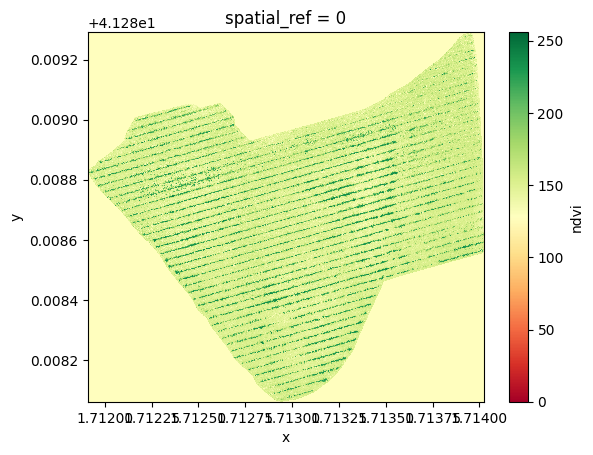

In [34]:
ndvi.plot(vmin = 0, vmax=256, cmap = "RdYlGn")

### Chipping the dataset for evalaution thorugh p2p (HD)

In [8]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x":512, "y":512}
input_overlap = {"x": 0, "y":0} # change this to 0 for the test-set

#shape (resolution) of input image
shape = da.shape
c = da.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(da, x)) 
chips = chips.set_geometry(chips["crs_geom"])

In [9]:
# lets drop all the chips which have NA values in them from the original raster.
ndvi_r = [(ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]),i) for i, row in chips.iterrows()]
ndvi_tf = [(img.values.min()==127 & img.values.max()==127) for img, i in ndvi_r]
chips["has_nan"]=  ndvi_tf
chips = chips[chips["has_nan"]!=True].copy().reset_index()


In [10]:
#saveit to disk
chips.drop(columns = ["crs_geom"]).to_file("data/canyelles_chips_512.geojson")


In [12]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x":256, "y":256}
input_overlap = {"x": 0, "y":0} # change this to 0 for the test-set

#shape (resolution) of input image
shape = da.shape
c = da.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(da, x)) 
chips = chips.set_geometry(chips["crs_geom"])

In [13]:
# lets drop all the chips which have NA values in them from the original raster.
ndvi_r = [(ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]),i) for i, row in chips.iterrows()]
ndvi_tf = [(img.values.min()==127 & img.values.max()==127) for img, i in ndvi_r]
chips["has_nan"]=  ndvi_tf
chips = chips[chips["has_nan"]!=True].copy().reset_index()


In [14]:
#saveit to disk
chips.drop(columns = ["crs_geom"]).to_file("data/canyelles_chips_256.geojson")

## 2. Visualizing

Let's visualize what we actually did.

In [18]:
# load the datasplits 

chips512 = gpd.read_file("../data/canyelles_chips_512.geojson")

chips256 = gpd.read_file("../data/canyelles_chips_256.geojson")

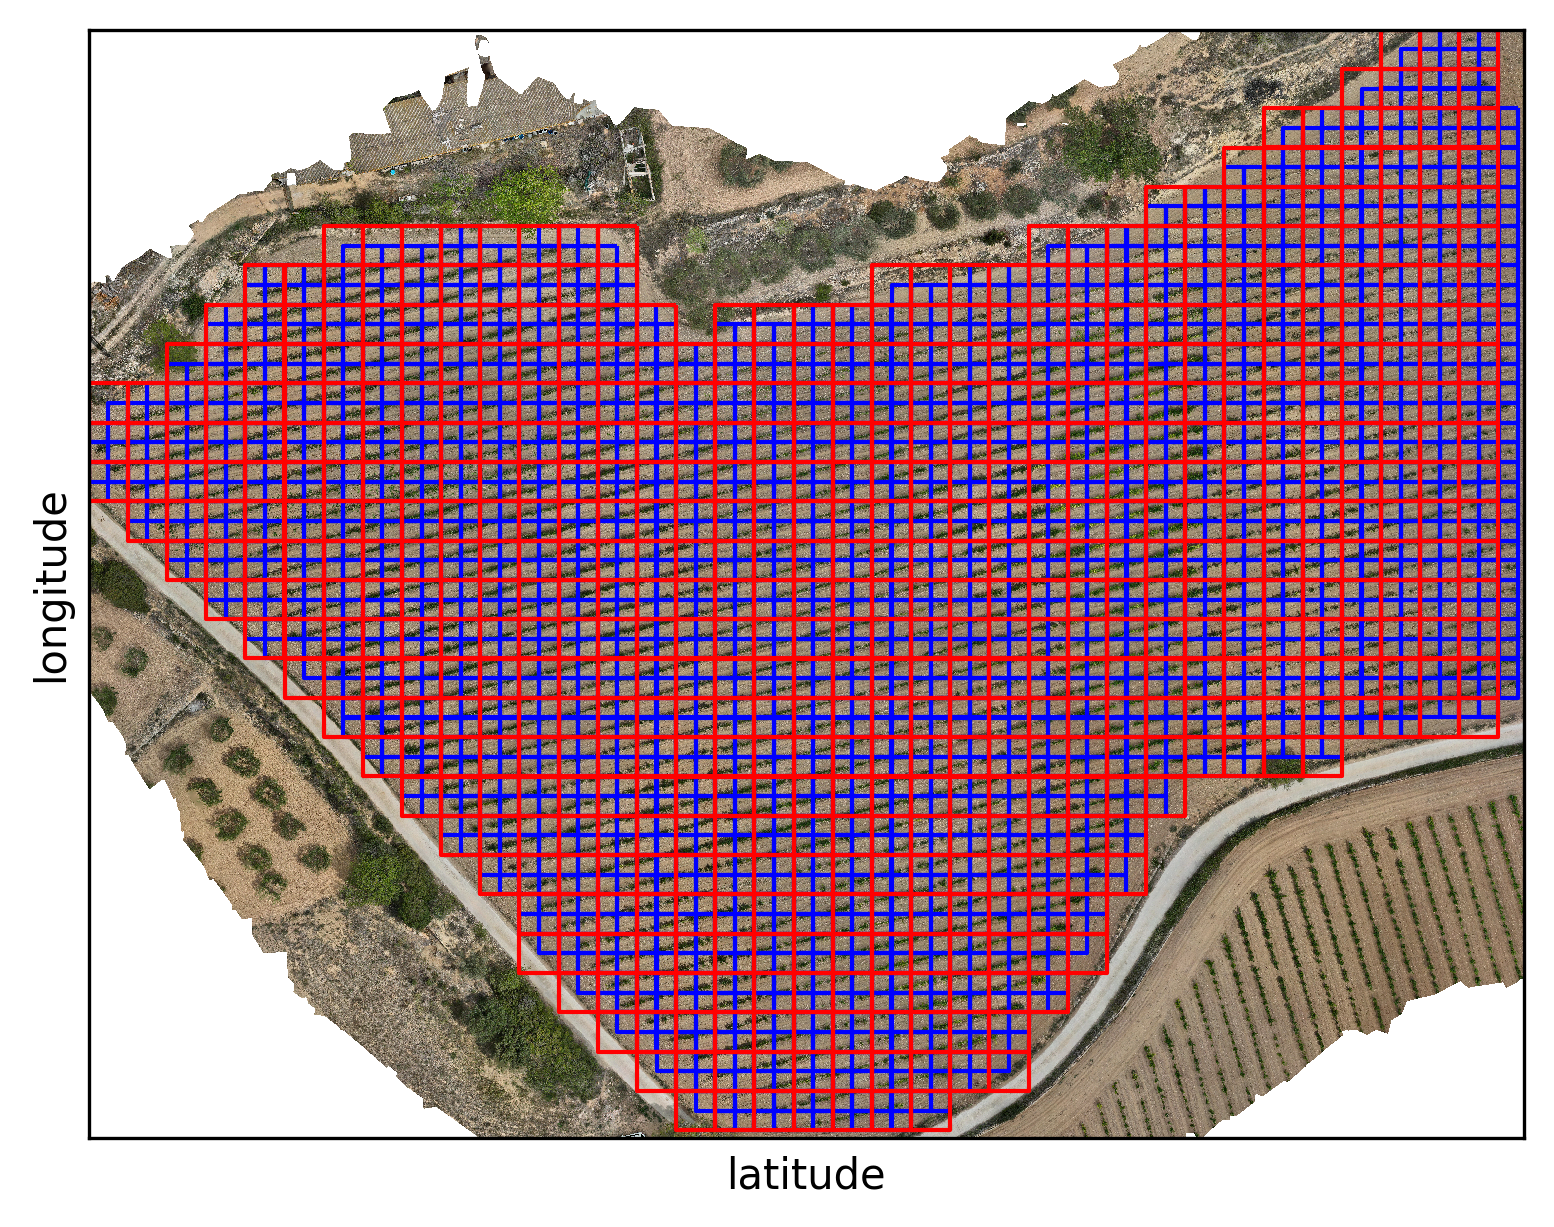

In [16]:
fig, ax = plt.subplots(dpi = 300)

rgb.plot.imshow(ax=ax)

ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

chips256.plot(ax=ax, facecolor= "none", edgecolor= 'blue' ,label="256")
chips512.plot(ax=ax, facecolor= "none", edgecolor= 'red' ,label="512")



# Create custom legend labels and colors using patches
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='512'),
    plt.Line2D([0], [0], color='blue', lw=2, label='256')
]

#plt.legend(handles=legend_elements, loc= "upper left")

plt.savefig("notebooks/figures/canyelles_chips.png", dpi =300)
plt.show()

In [18]:
rgb.rio.to_raster("data/canyelles/orthos/cropped_rgb_230609.tif")
ndvi.rio.to_raster("data/canyelles/orthos/cropped_ndvi_230609.tif")

## 3. Actual subsetting of the imagery 
Requires the orthomosaic, coloured to nice colours and called 'da', see above.

#### Starting with the RGB: style A

In [12]:
#clip RGB set:
chips = chips256.to_crs(rgbvi.rio.crs)
rgbs = [rgb.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chips.iterrows()]
# transpose to RGB instead of BANDS
rgbs = [np.transpose(img.values, (1,2,0)) for img in rgbs]

NameError: name 'rgb' is not defined

#### repeat for NDVI: Style B

In [24]:
#clip NDVI set

ndvis = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chips.iterrows()]
# transpose to ndvi img
ndvis = [img.values for img in ndvis]

In [16]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [26]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("data")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "trgb_canyelles_2022_chips_256")
export_image_list(test_path, rgbs)

#for style B: aka ndvi
test_path = os.path.join(path, "ndvi_canyelles_2022_chips_256")
export_image_list(test_path, ndvis)


# RGBVIS: for SSIM and PSNR calcs: needs to be in chip-format :/


In [57]:
# load the datasplits 
chips256 = gpd.read_file("../data/chips_2022v2_256.geojson")

In [74]:
rgb = rxr.open_rasterio("../data/orthos/rgb_2022.tif")
ms = rxr.open_rasterio("../data/orthos/ms_2021.tif")

In [75]:
rgb = rgb.rio.reproject_match(ms).sel(band=[1,2,3])

In [76]:
rgbvi = ug.compute.calc_rgbvi(rgb, red_id=1, green_id=2, blue_id =3, rescale=True)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [77]:
#clip RGBVI set:
chips = chips256
rgbvis = [rgbvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chips.iterrows()]
# transpose to RGB instead of BANDS
rgbvis =  [img.values for img in rgbvis]

In [78]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [79]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("../data")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "rgbvi_btg_2022_chips_256")
export_image_list(test_path, rgbvis)



# repeat RGBVI chipping for CANYELLES

In [21]:
# load the datasplits 

chips512 = gpd.read_file("../data/canyelles_chips_512.geojson")

chips256 = gpd.read_file("../data/canyelles_chips_256.geojson")
rgb = rxr.open_rasterio("../data/canyelles/orthos/rgb_230609.tif")

In [22]:
#redo calculation because of integer/float scaling (needs to be in 0:256)
rgbvi = ug.compute.calc_rgbvi(rgb, red_id=1, green_id=2, blue_id =3, rescale=True)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [23]:
#clip RGBVI set:
chips = chips256
rgbvis = [rgbvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chips.iterrows()]
# transpose to RGB instead of BANDS
rgbvis =  [img.values for img in rgbvis]

In [24]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [25]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("../data")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "rgbvi_canyelles_2023_chips_256")
export_image_list(test_path, rgbvis)



# Repeat for BTG2021-test


In [27]:
# load the datasplits 

chips256 = gpd.read_file("../data/test_chips_2021.geojson")
ortho  = rxr.open_rasterio("../data/orthos/ms_2021.tif",mode = "r", chunks=True).sel(band=[1,2,3])
r = 7500
g = 7500
b = 6000
r_new = ug.compute.scale_band_to_min_max(ortho.sel(band=3), min = 0, max = r)
g_new =  ug.compute.scale_band_to_min_max(ortho.sel(band=2), min = 0, max = g)
b_new =  ug.compute.scale_band_to_min_max(ortho.sel(band=1), min = 0, max = b)
rgb = xr.combine_nested([r_new, g_new, b_new],concat_dim = "band")

In [28]:
rgbvi = ug.compute.calc_rgbvi(rgb, red_id=1, green_id=2, blue_id =3, rescale=True)

In [29]:
#clip RGBVI set:
chips = chips256
rgbvis = [rgbvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chips.iterrows()]
# transpose to RGB instead of BANDS
rgbvis =  [img.values for img in rgbvis]

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\dask\core.py:121: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\dask\array\chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


In [30]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [31]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("../data")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "rgbvi_btg_2021_chips_256")
export_image_list(test_path, rgbvis)